# Kuzushiji Kanji

In [1]:
import os

# https://github.com/rois-codh/kmnist
if "kkanji.tar" not in os.listdir("./"):
    !wget http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar
    !tar -xf "./kkanji.tar" 

data_dir = "./kkanji2"

In [2]:
try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow_addons
    import tensorflow_addons as tfa

In [3]:
import shutil

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

Found GPU at: /device:GPU:0


In [4]:
# Keep only the characters with at least 50 images.

n_min_chars = 50

char_list = np.array(sorted(os.listdir(data_dir)))

num_chars = np.array([len(os.listdir(os.path.join(data_dir, c))) for c in char_list])

want_char_list = []

for c in char_list:
    if len(os.listdir(os.path.join(data_dir, c))) >= n_min_chars:
        want_char_list.append(c)

want_char_list = np.array(want_char_list)

unwanted_char_list = list(set(char_list) - set(want_char_list))

for uc in unwanted_char_list:
    shutil.rmtree(os.path.join(data_dir, uc))

In [5]:
N_classes = len(want_char_list)

print(len(want_char_list))

568


In [6]:
# Load and pre-process the images.

batch_size = 20
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    label_mode = "categorical",
    subset = "training",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    label_mode = "categorical",
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size)

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
#noise_layer = tf.keras.layers.GaussianNoise(stddev = 0.15, seed = None)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
#train_ds = train_ds.map(lambda x, y: (noise_layer(x), y))

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Found 110578 files belonging to 568 classes.
Using 88463 files for training.
Found 110578 files belonging to 568 classes.
Using 22115 files for validation.


In [7]:
#image_batch, labels_batch = next(iter(train_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [8]:
class CNNClassifier(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, 
                                            padding = "same", activation = "relu", 
                                            input_shape = (img_height, img_width, 1))
        self.pool1 = tf.keras.layers.MaxPool2D([2, 2])

        self.conv2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, 
                                            padding = "same", activation = "relu")
        self.pool2 = tf.keras.layers.MaxPool2D([2, 2])

        self.flatten = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.5)

        self.linear1 = tf.keras.layers.Dense(1024, activation = "relu")
        self.dropout2 = tf.keras.layers.Dropout(0.5)

        self.linear2 = tf.keras.layers.Dense(N_classes, activation = "softmax")

    def call(self, x, training = False):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        if training == True:
            x = self.dropout1(x)

        x = self.linear1(x)
        if training == True:
            x = self.dropout2(x)

        return self.linear2(x)

In [9]:
def make_tf_model(input_shape = [img_height, img_width, 1]):
    model = CNNClassifier()
    inputs = tf.keras.layers.Input(input_shape)
    outputs = model(inputs)
    return tf.keras.Model(inputs = inputs, outputs = outputs)

def make_tf_model_on_device(device = "/device:GPU:0"):
    with tf.device(device):
        tf_model = make_tf_model()
        tf_model.compile(loss = tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.25, 
                                                                    gamma = 2, 
                                                                    reduction = tf.keras.losses.Reduction.AUTO),
                         optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                         metrics = tf.keras.metrics.CategoricalAccuracy())
    return tf_model

In [10]:
tf_model = make_tf_model_on_device(DEVICE_NAME)
  
history = tf_model.fit(train_ds, batch_size = batch_size, epochs = 10, validation_data = val_ds)

Epoch 1/10
4424/4424 [==============================] - 72s 15ms/step - loss: 0.5665 - categorical_accuracy: 0.5343 - val_loss: 0.1969 - val_categorical_accuracy: 0.8020
Epoch 2/10
4424/4424 [==============================] - 30s 7ms/step - loss: 0.2386 - categorical_accuracy: 0.7510 - val_loss: 0.1338 - val_categorical_accuracy: 0.8640
Epoch 3/10
4424/4424 [==============================] - 31s 7ms/step - loss: 0.1685 - categorical_accuracy: 0.8136 - val_loss: 0.1151 - val_categorical_accuracy: 0.8789
Epoch 4/10
4424/4424 [==============================] - 30s 7ms/step - loss: 0.1341 - categorical_accuracy: 0.8472 - val_loss: 0.1038 - val_categorical_accuracy: 0.8912
Epoch 5/10
4424/4424 [==============================] - 30s 7ms/step - loss: 0.1123 - categorical_accuracy: 0.8673 - val_loss: 0.0979 - val_categorical_accuracy: 0.8984
Epoch 6/10
4424/4424 [==============================] - 30s 7ms/step - loss: 0.0988 - categorical_accuracy: 0.8823 - val_loss: 0.0949 - val_categorical_ac

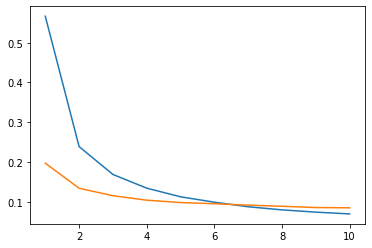

In [11]:
plt.plot(range(1, len(history.history["loss"]) + 1, 1), history.history["loss"])
plt.plot(range(1, len(history.history["val_loss"]) + 1, 1), history.history["val_loss"])
plt.show()